In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt

import pickle

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers, models
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import AdamW

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay


import wandb
from wandb.integration.keras import WandbMetricsLogger, WandbModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

In [2]:
os.environ["WANDB_API_KEY"] = "cd71d6f2249981dffae87be7baa57f08fe64c95e"
os.environ["WANDB_MODE"] = "online"
wandb.login()

wandb: Currently logged in as: omarhariri (omarhariri-syrian-private-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

In [3]:
run = wandb.init(
    project="driver-drowsiness-cnn",
    name="cnn_v4",
    config={
        "img_size": 64,
        "batch_size": 32,
        "epochs": 30,
        "optimizer": "AdamW",
        "architecture": "CNN_v3",
        "learning_rate": 1e-3,
        "weight_decay": 1e-4,
        "loss": "binary_crossentropy"
    }
)

config = wandb.config


In [4]:
# Paths to data splits
TRAIN_DIR = "../data/train"
VAL_DIR = "../data/val"
TEST_DIR = "../data/test"

Found 2762 images belonging to 2 classes.
Found 405 images belonging to 2 classes.
Found 407 images belonging to 2 classes.


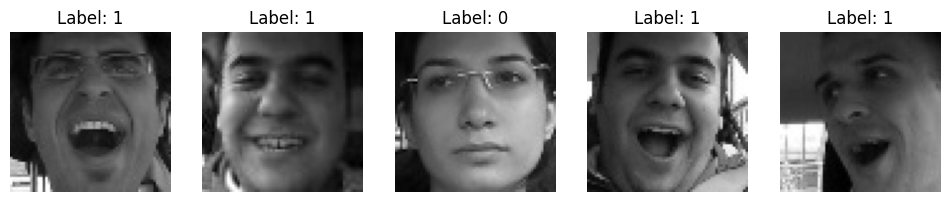

In [5]:
# Load images with ImageDataGenerator (Binary classification)

# Rescale only
train_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
val_datagen = ImageDataGenerator(rescale=1.0 / 255.0)
test_datagen = ImageDataGenerator(rescale=1.0 / 255.0)

# Train generator
train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(config.img_size, config.img_size),
    color_mode="grayscale",
    batch_size=config.batch_size,
    class_mode="binary",
    shuffle=True
)

# Validation generator
val_generator = val_datagen.flow_from_directory(
    VAL_DIR,
    target_size=(config.img_size, config.img_size),
    color_mode="grayscale",
    batch_size=config.batch_size,
    class_mode="binary",
    shuffle=False
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    TEST_DIR,
    target_size=(config.img_size, config.img_size),
    color_mode="grayscale",
    batch_size=config.batch_size,
    class_mode="binary",
    shuffle=False
)

# Preview a few training images
x_batch, y_batch = next(train_generator)

fig, axes = plt.subplots(1, 5, figsize=(12, 3))
for i in range(5):
    axes[i].imshow(x_batch[i].reshape((config.img_size, config.img_size)), cmap="gray")
    axes[i].set_title(f"Label: {int(y_batch[i])}")
    axes[i].axis("off")

plt.show()


In [6]:
print(train_generator.class_indices)

{'normal': 0, 'yawn': 1}


In [7]:
model = models.Sequential([
    layers.Input(shape=(config.img_size, config.img_size, 1)),

    # Block 1
    layers.Conv2D(32, (3,3), activation="relu", kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Block 2
    layers.Conv2D(64, (3,3), activation="relu", kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Block 3
    layers.Conv2D(64, (3,3), activation="relu", kernel_regularizer=l2(1e-4)),
    layers.BatchNormalization(),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),

    # Classifier
    layers.Flatten(),
    layers.Dense(128, activation="relu", kernel_regularizer=l2(1e-4)),
    layers.Dropout(0.5),

    layers.Dense(1, activation="sigmoid")
])

optimizer = AdamW(
    learning_rate=1e-3,
    weight_decay=1e-4
)

model.compile(
    optimizer=optimizer,
    loss="binary_crossentropy",
    metrics=["accuracy"]
)


In [8]:
model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 62, 62, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 62, 62, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 31, 31, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 29, 29, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 29, 29, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 351,553 (1.34 MB)

 Trainable params: 351,233 (1.34 MB)

 Non-trainable params: 320 (1.25 KB)

In [9]:
early_stop = EarlyStopping(
    monitor="val_loss",
    patience=4,
    restore_best_weights=True,
    verbose=1
)

checkpoint = WandbModelCheckpoint(
    filepath="../models/cnn_v4/best.keras",
    monitor="val_loss",
    save_best_only=True
)

reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=1
)

callbacks = [
    early_stop,
    checkpoint,
    reduce_lr,
    WandbMetricsLogger()
]


wandb: WARNING When using `save_best_only`, ensure that the `filepath` argument contains formatting placeholders like `{epoch:02d}` or `{batch:02d}`. This ensures correct interpretation of the logged artifacts.


In [10]:
history = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=config.epochs,
    callbacks=callbacks,
    verbose=1
)


Epoch 1/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 85s 840ms/step - accuracy: 0.7369 - loss: 0.8173 - val_accuracy: 0.7309 - val_loss: 1.5202 - learning_rate: 0.0010
Epoch 2/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 37s 425ms/step - accuracy: 0.8756 - loss: 0.3554 - val_accuracy: 0.7309 - val_loss: 1.0588 - learning_rate: 0.0010
Epoch 3/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 39s 449ms/step - accuracy: 0.8995 - loss: 0.3066 - val_accuracy: 0.7309 - val_loss: 1.2438 - learning_rate: 0.0010
Epoch 4/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 36s 414ms/step - accuracy: 0.9081 - loss: 0.2885 - val_accuracy: 0.8198 - val_loss: 0.5147 - learning_rate: 0.0010
Epoch 5/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 37s 422ms/step - accuracy: 0.9241 - loss: 0.2420 - val_accuracy: 0.8642 - val_loss: 0.4500 - learning_rate: 0.0010
Epoch 6/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 44s 499ms/step - accuracy: 0.9367 - loss: 0.2276 - val_accuracy: 0.7556 - val_loss: 0.6417 - learning_rate: 0.0010
Epoch 7/30
87/87 ━━━━━━━━━━━━━━━━━━━━ 43s 499ms/step - accuracy: 0.9285 - loss: 0.

In [11]:
# Evaluate overall accuracy/loss
val_loss, val_acc = model.evaluate(val_generator, verbose=0)
print(f"Val Accuracy: {val_acc:.4f}, Val Loss: {val_loss:.4f}")


Val Accuracy: 0.9160, Val Loss: 0.4117


In [12]:
test_loss, test_acc = model.evaluate(test_generator)
wandb.log({
    "test_loss": test_loss,
    "test_accuracy": test_acc
})

13/13 ━━━━━━━━━━━━━━━━━━━━ 6s 483ms/step - accuracy: 0.9538 - loss: 0.1957


In [13]:
# Predict probabilities
y_pred_probs = model.predict(test_generator, verbose=1)

# Convert probabilities → class indices (0 or 1)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()  # flatten

# True labels
y_true = test_generator.classes

print("Predictions done.")

13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 154ms/step
Predictions done.


In [14]:
class_names = list(test_generator.class_indices.keys())
report = classification_report(
    y_true,
    y_pred,
    target_names=class_names,
    digits=4,
)

print("\nClassification Report:\n")
print(report)


Classification Report:

              precision    recall  f1-score   support

      normal     0.9344    0.9596    0.9468       297
        yawn     0.8824    0.8182    0.8491       110

    accuracy                         0.9214       407
   macro avg     0.9084    0.8889    0.8980       407
weighted avg     0.9204    0.9214    0.9204       407



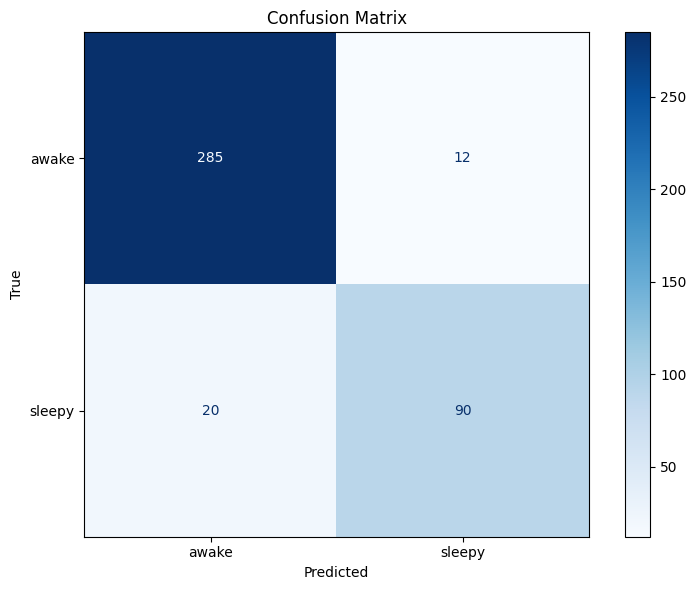

In [15]:
# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
cmd = ConfusionMatrixDisplay(cm, display_labels=['awake','sleepy'])
cmd.plot(cmap=plt.cm.Blues, values_format='d', ax=plt.gca())
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

In [16]:
with open("../models/cnn_v4/history.pkl", "wb") as f:
    pickle.dump(history.history, f)

In [17]:
wandb.finish()

epoch/accuracy,▁▄▆▆▆▇▇▇▇▇███
epoch/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
epoch/learning_rate,██████████▃▃▁
epoch/loss,█▄▄▃▂▂▂▂▂▂▂▁▁
epoch/val_accuracy,▁▁▁▄▆▂▇▆██▆██
epoch/val_loss,█▅▆▂▁▂▁▂▁▂▁▁▁
test_accuracy,▁
test_loss,▁
epoch/accuracy,0.95655
epoch/epoch,12
epoch/learning_rate,9e-05
